In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.width', 800)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

In [2]:
con = sqlite3.connect('database.sqlite')
df = pd.read_sql_query("SELECT * FROM Reviews", con)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df.shape

(568454, 10)

In [4]:
df.dtypes


Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

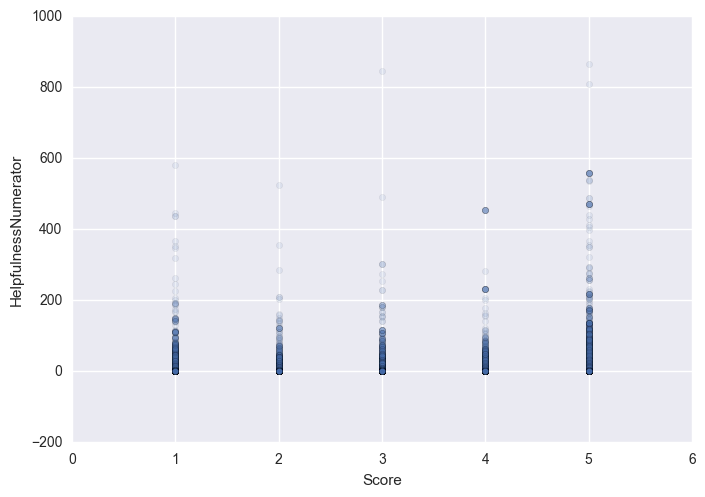

In [5]:
df.plot(kind="scatter", x="Score", y="HelpfulnessNumerator", alpha=0.1)

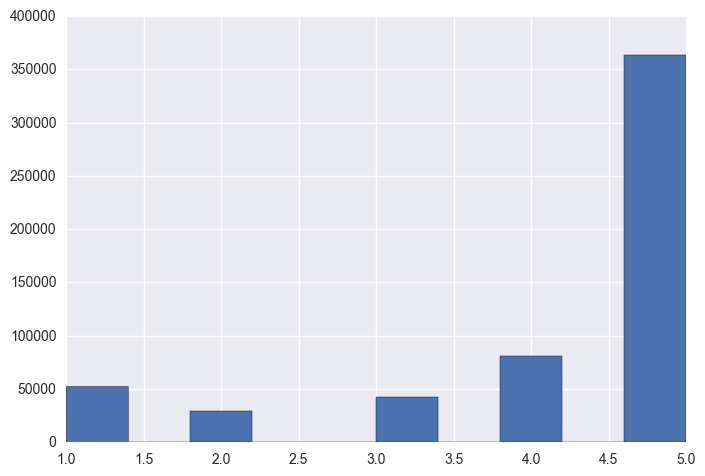

In [6]:
df['Score'].hist()

In [7]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


### Prepare the data

In [8]:
# We want to use both the summary and the text of review to classify, so we merge them both into a new column.
df['review'] = df['Summary'] + '.' + df['Text']

In [9]:
#we transform reviews with more than 3 stars into Positive, and the rest of review into Negative:
def get_class(Score):
    if Score > 3:
        return 'positive'
    else:
        return 'negative'

In [10]:
# Transform the number of socres into positive and negative tags.
df['category'] = df['Score'].apply(get_class)

In [11]:
df = df[['review', 'category']]
df.head()

,review,category
0,Good Quality Dog Food.I have bought several of...,positive
1,Not as Advertised.Product arrived labeled as J...,negative
2,"""Delight"" says it all.This is a confection tha...",positive
3,Cough Medicine.If you are looking for the secr...,negative
4,Great taffy.Great taffy at a great price. The...,positive


In [12]:
df['category'].value_counts()

positive    443777
negative    124677
Name: category, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split
#split data into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['category'], random_state=0)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(426340, 111130)

## linear support vector machine (SVM)

In [15]:
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, n_iter=5, random_state=42)),
 ])
text_clf = text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)            

0.785967603473268

##  Naïve Bayes Classifier

In [16]:
#make the vectorizer => transformer => classifier easier to work with, scikit-learn provides a Pipeline class that behaves like a compound classifier:
text_clf2 = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
])

In [17]:
text_clf2 = text_clf2.fit(X_train, y_train)

In [18]:
#Evaluation of the performance on the test set
predicted2 = text_clf2.predict(X_test)
np.mean(predicted2 == y_test)  

0.82974935615069589